In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce
import time
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA

In [21]:
def import_data(path,id_column,var_column,new_id_column):
    os.chdir(path)
    file_names = os.listdir()
    df_all = pd.DataFrame(columns = [id_column,var_column])
    for file_name in file_names:
        df = pd.read_csv(file_name)
        df = df[[id_column,var_column]]
        df = df.dropna()
        df[id_column] = df[id_column].astype("int")
        df_all = pd.concat([df_all,df],axis = 0)
    df_all = df_all.drop_duplicates(subset = id_column).reset_index(drop = True)
    df_all.rename(columns = {id_column:new_id_column}, inplace = True)
    return df_all
def get_tgAcceleration(df,speed,time):
    """Calculate tangential acceleration."""
    dVehSpdLgtA = df[speed].diff() / 3.6
    dt = df[time].diff()
    df["tg_acceleration"] = dVehSpdLgtA / dt
    return df
def get_dPinion(df,pinion,time):
    """Calculate dpinion"""
    dpinion = df[pinion].diff()
    dt = df[time].diff()
    df["dpinion"] = dpinion / dt
    return df
def timestamp2date(timestamp):
    """Convert timestamp to datetime."""
    timeArray = time.localtime(timestamp)
    formatted_time = time.strftime("%Y-%m-%d %H:%M:%S", timeArray)
    return formatted_time
def partition_journey(df,time):
    df["dt"] = df[time].diff()
    df["stop"] = df["dt"] != 1
    df["journeyID"] = df["stop"].cumsum()
    df = df.drop(["dt","stop"],axis = 1)
    return df
def kde2D(x, y, bandwidth, xbins=10j, ybins=10j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""
    
    # create grid of sample locations (default: 10x10)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    zz = np.reshape(z, xx.shape)
    z_norm = z / z.sum()
    z_norm= z_norm.ravel()
    return xx,yy,zz,z_norm
def speed_dpinion_factor(df,journeyID,speed,dpinion,bandwidth,bins_num,components_num):
    results = df.groupby(journeyID).apply(lambda x:kde2D(x[speed],x[dpinion],bandwidth = bandwidth))
    results = [{journeyID:index, "z_norm":results[index][-1]} for index in results.index]
    z_norms = pd.DataFrame(results)
    z_norms = pd.DataFrame(z_norms["z_norm"].to_list(),columns = ["z_norm" + str(i) for i in range(1,bins_num+1)])
    mean = z_norms.mean(axis = 0)
    std = z_norms.std(axis = 0)
    z_norms = (z_norms - mean)/std
    pca = PCA(n_components = components_num)
    pca.fit(z_norms)
    print("explained_variance_ratio_: ",pca.explained_variance_ratio_)
    print("cummulative explained_variance_ratio_: ",np.cumsum(pca.explained_variance_ratio_))
    pca_score = np.dot(z_norms,pca.components_.T)
    first_pca_score = pca_score[:,0]
    journeyIDs = [result[journeyID] for result in results]
    first_pca_score = pd.Series(first_pca_score,index = journeyIDs)
    first_pca_score.index.name = journeyID
    first_pca_score.name = "steering"
    return first_pca_score
def speed_tgAcc_factor(df,journeyID,speed,tg_acc,bandwidth,bins_num,components_num):
    results = df.groupby(journeyID).apply(lambda x:kde2D(x[speed],x[tg_acc],bandwidth = bandwidth))
    results = [{journeyID:index, "z_norm":results[index][-1]} for index in results.index]
    z_norms = pd.DataFrame(results)
    z_norms = pd.DataFrame(z_norms["z_norm"].to_list(),columns = ["z_norm" + str(i) for i in range(1,bins_num+1)])
    mean = z_norms.mean(axis = 0)
    std = z_norms.std(axis = 0)
    z_norms = (z_norms - mean)/std
    pca = PCA(n_components = components_num)
    pca.fit(z_norms)
    print("explained_variance_ratio_: ",pca.explained_variance_ratio_)
    print("cummulative explained_variance_ratio_: ",np.cumsum(pca.explained_variance_ratio_))
    pca_score = np.dot(z_norms,pca.components_.T)
    first_pca_score = pca_score[:,0]
    journeyIDs = [result[journeyID] for result in results]
    first_pca_score = pd.Series(first_pca_score,index = journeyIDs)
    first_pca_score.index.name = journeyID
    first_pca_score.name = "instability"
    return first_pca_score
def make_radar_chart(name, stats, avg_stats,attribute_labels,
                     plot_markers):

    angles = np.linspace(0, 2*np.pi, len(attribute_labels), endpoint=False)
    stats = np.concatenate((stats,[stats[0]]))
    avg_stats = np.concatenate((avg_stats,[avg_stats[0]]))
    angles = np.concatenate((angles,[angles[0]]))
    attribute_labels = np.concatenate((attribute_labels,[attribute_labels[0]]))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-',color = "red" ,linewidth=2,label = "score")
    ax.fill(angles, stats,color = "red", alpha=0.25)
    ax.plot(angles, avg_stats, 'o-',color = "blue" ,linewidth=2,label = "average score")
    ax.fill(angles, avg_stats,color = "blue" ,alpha=0.25)
    
    ax.set_thetagrids(angles * 180/np.pi, attribute_labels)
    plt.yticks(markers)
    plt.legend(bbox_to_anchor=(1.3, 1), loc = "right")
    plt.title(name, x = 0.5,y=1.1)
    ax.grid(True)

    return plt.show()

In [3]:
# data loading
# 1029低配数据
path = r"D:\Research\UBI车险\data\real_data\1029低配数据"
id_column = "time_1"
var_column = "PinionSteerAgGroupPinionSteerAg1"
new_id_column = "time"
df_pinion = import_data(path,id_column,var_column,new_id_column)

In [4]:
path = r"D:\Research\UBI车险\data\real_data\1029低配数据"
id_column = "time_2"
var_column = "AccrPedlLnrAccrPedlRat"
new_id_column = "time"
df_Accr = import_data(path,id_column,var_column,new_id_column)

In [5]:
path = r"D:\Research\UBI车险\data\real_data\1029低配数据"
id_column = "time_3"
var_column = "BrkPedlTrvlAct"
new_id_column = "time"
df_Brk = import_data(path,id_column,var_column,new_id_column)

In [6]:
path = r"D:\Research\UBI车险\data\real_data\10292022续航数据\低配车\1029_CAN_res\CAN_res"
id_column = "time_71"
var_column = "VehSpdLgtA"
new_id_column = "time"
df_Veh = import_data(path,id_column,var_column,new_id_column)

C:\Users\lenovo\AppData\Local\Temp/ipykernel_12652/3445526404.py:5: DtypeWarning: Columns (6,12,42,84,90,140,152) have mixed types.Specify dtype option on import or set low_memory=False.
  df_Veh = import_data(path,id_column,var_column,new_id_column)


In [7]:
# data merge
df_list = [df_pinion,df_Accr,df_Brk,df_Veh]
df_merged = reduce(lambda left,right: pd.merge(left,right,on = ["time"],how = "inner"),df_list)

In [8]:
# data cleasing
df_merged["date"] = df_merged["time"].apply(timestamp2date)
df_merged["VehSpdLgtA"] = df_merged["VehSpdLgtA"] * 3.6
df_merged = partition_journey(df = df_merged, time = "time")
df_merged = df_merged.groupby("journeyID").apply(get_tgAcceleration,speed= "VehSpdLgtA",time = "time")
df_merged = df_merged.groupby("journeyID").apply(get_dPinion,pinion = "PinionSteerAgGroupPinionSteerAg1",time = "time")
df_merged = df_merged.groupby("journeyID").apply(lambda x:x.iloc[1:]).reset_index(drop = True)
df_merged["is_meaningless"] = df_merged.groupby("journeyID")["VehSpdLgtA"].transform(lambda v: True if (np.sum(v) == 0 or len(v) < 3 * 60) else False)
df_merged = df_merged[~df_merged["is_meaningless"]].reset_index(drop = True)

In [22]:
# data process
## radial instability risk factor
dpinion_risk_factor = speed_dpinion_factor(df = df_merged,journeyID = "journeyID",speed = "VehSpdLgtA",dpinion = "dpinion",bandwidth = 0.75,bins_num = 100,components_num = 5)

explained_variance_ratio_:  [0.46090102 0.18553216 0.0852916  0.07662655 0.06409007]
cummulative explained_variance_ratio_:  [0.46090102 0.64643319 0.73172478 0.80835133 0.8724414 ]


In [23]:
## tangential instability risk factor 
tang_risk_factor = speed_tgAcc_factor(df = df_merged, journeyID = "journeyID",speed = "VehSpdLgtA",tg_acc = "tg_acceleration",bandwidth = 0.75,bins_num = 100,components_num = 5)

explained_variance_ratio_:  [0.32613892 0.25929917 0.12848309 0.09391463 0.06307224]
cummulative explained_variance_ratio_:  [0.32613892 0.5854381  0.71392119 0.80783581 0.87090805]


In [24]:
## fatigue risk factor
fatigue_risk_factor = df_merged.groupby("journeyID")["time"].apply(lambda v:v.iloc[-1] - v.iloc[0])
fatigue_risk_factor.name = "Fatigue"

In [25]:
risk_factors = pd.concat([dpinion_risk_factor,tang_risk_factor,fatigue_risk_factor],axis = 1)
risk_factors = risk_factors.apply(lambda v: (v - np.min(v)) / (np.max(v) - np.min(v)) * 100)
risk_factors = 100 - risk_factors
risk_factors

,steering,instability,Fatigue
journeyID,,,
3,92.592849,39.879619,100.000000
8,96.594864,40.274735,98.245797
9,92.191801,81.093314,53.774668
11,100.000000,94.578454,0.000000
12,97.445400,86.114774,65.939229
13,0.000000,83.160884,82.906965
14,66.501404,83.179657,53.419651
15,42.891875,100.000000,61.156938
16,96.868477,12.213014,77.602590


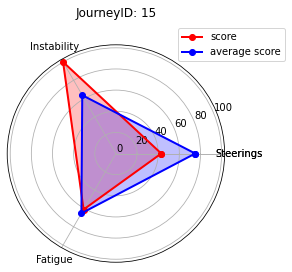

In [34]:
# data visualize
journeyID = 15
df_vis = df_merged[df_merged["journeyID"] == journeyID]
stats_vis = risk_factors.loc[journeyID]

labels=['Steerings', 'Instability', 'Fatigue']
markers = [0, 20, 40,60,80,100]
avg_stats = risk_factors.mean()
make_radar_chart("JourneyID: {}".format(journeyID), stats = list(stats_vis),avg_stats = avg_stats, attribute_labels = labels,
                     plot_markers = markers)

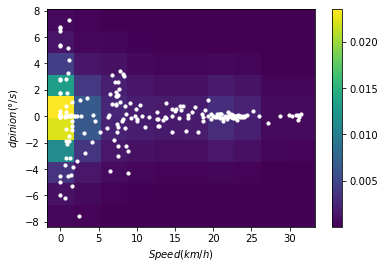

In [27]:
x,y = df_vis["VehSpdLgtA"],df_vis["dpinion"]
xx,yy,zz,z_norm = kde2D(x,y,bandwidth = 2)
plt.pcolormesh(xx, yy, zz,shading='auto')
plt.colorbar()
plt.scatter(x, y, s=10, facecolor='white')
plt.xlabel("$Speed(km/h)$")
plt.ylabel("$dpinion(°/s)$")
plt.show()

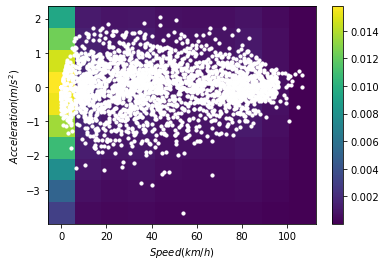

In [33]:
x,y = df_vis["VehSpdLgtA"],df_vis["tg_acceleration"]
xx,yy,zz,z_norm = kde2D(x,y,bandwidth = 2)
plt.pcolormesh(xx, yy, zz,shading='auto')
plt.colorbar()
plt.scatter(x, y, s=10, facecolor='white')
plt.xlabel("$Speed(km/h)$")
plt.ylabel("$Acceleration(m/s^2)$")
plt.show()

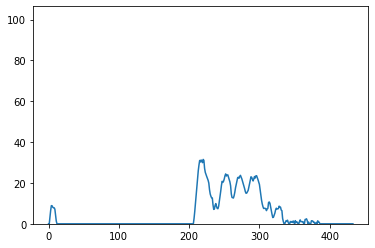

In [16]:
df_vis["VehSpdLgtA"].plot()
plt.ylim(np.min(df_merged["VehSpdLgtA"]),np.max(df_merged["VehSpdLgtA"]))
plt.show()

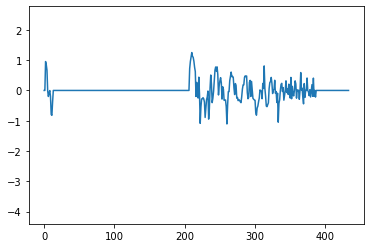

In [17]:
df_vis["tg_acceleration"].plot()
plt.ylim(np.min(df_merged["tg_acceleration"]),np.max(df_merged["tg_acceleration"]))
plt.show()

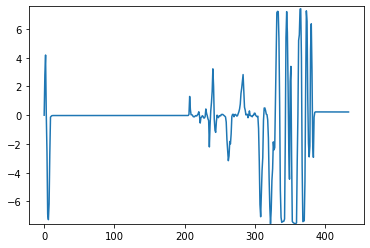

In [18]:
df_vis["PinionSteerAgGroupPinionSteerAg1"].plot()
plt.ylim(np.min(df_merged["PinionSteerAgGroupPinionSteerAg1"]),np.max(df_merged["PinionSteerAgGroupPinionSteerAg1"]))
plt.show()

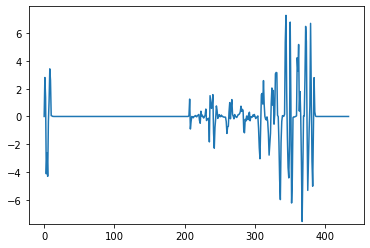

In [19]:
df_vis["dpinion"].plot()
plt.ylim(np.min(df_merged["dpinion"]),np.max(df_merged["dpinion"]))
plt.show()